In [1250]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
from scipy.interpolate import interp2d

In [1395]:
class OptionMilstein():

    def __init__(self, mu, sigma0, sigma1, k, s0, T, r, M, precision = 1):
        self.mu = mu
        self.sigma0 = sigma0
        self.sigma1 = sigma1
        self.k = k
        self.s0 = s0
        self.T = T
        self.r = r
        self.M = M # Nº of simulations
        self.h = 1/(precision*365) #Timesteps size

    def a(self, s):
        return s * self.mu
    
    def b(self, s, t):
        return s*(self.sigma0 + self.sigma1 * math.cos((2*math.pi*s)/self.k) * \
                math.sin((2*math.pi*t)/self.k))

    def db(self, s, t):
        return -((2*math.pi)/self.k) * s * math.sin((2*math.pi*s)/self.k) * \
                math.sin((2*math.pi*t)/self.k) * self.sigma1 + b(s,t)/s

    
    def milstein(self, dw, h):

        lenght = len(dw)
        path = np.zeros(lenght)
        path[0] = self.s0

        for i in range(lenght-1):

            t = (i+1) * h
            path[i+1] = path[i] + self.a(path[i]) * h + self.b(path[i], t) * \
                np.sqrt(h) * dw[i] + (0.5 * self.b(path[i], t) * \
                    self.b(path[i], t) * (h * dw[i]*dw[i] - h))

        return path


    def talayTubaro(self,function):
        
        v1 =  np.zeros(self.M) #Expectation with finer disctretization
        v2 =  np.zeros(self.M) 

        if not hasattr(self,'p1'): #Check if the paths were already created.
                    
            size1 = 2*int(self.T/self.h)
            size2 = int(self.T/self.h)

            self.p1 = np.empty([self.M, size1])
            self.p2 = np.empty([self.M, size2])

            for i in range(self.M):

                dw1 = np.random.standard_normal(size1) #Brownian Motion
                #Aggregated dW. Remembering to normalize by sqrt(2) 
                # for variance = 1
                dw2 = [(dw1[2*j]+dw1[2*j+1])/math.sqrt(2) for j in range(size2)]
                
                self.p1[i] = self.milstein(dw1, self.h*0.5)
                self.p2[i] = self.milstein(dw2, self.h)
        
        v1 = np.array([function(self.p1[i]) for i in range(self.M)])
        v2 = np.array([function(self.p2[i]) for i in range(self.M)])

        return 2*v1.mean() - v2.mean()


    def callPayoff(self, s):

        if hasattr(s, "__len__"):
            return np.maximum(s[-1]-self.k,0)
        else:
            return np.maximum(s-self.k,0)

    def asianPayoff(self, s):

        return np.maximum(s.mean()-self.k,0)


    def callPrice(self):

        return self.talayTubaro(self.callPayoff)

    def asianPrice(self):

        return self.talayTubaro(self.asianPayoff)


In [1396]:
a = OptionMilstein(0.05, 0.2, 0, 10, 10, 1,  0.05, 2000,1)
print(a.callPrice())
print(a.asianPrice())

1.103164203713228
0.6025850758686686


In [1419]:
class FTCS():

    def __init__(self, sigma0, sigma1, strike , sMax, T, r, precision = 1):
        self.sigma0 = sigma0
        self.sigma1 = sigma1
        self.strike = strike
        self.T = T
        self.r = r
        self.sMax = sMax
        self.L = self.sMax - self.strike * np.exp(-self.r * self.T)
        self.ds = sMax * np.sqrt(1/(364*precision)) 
        self.dt = 1/(365 * precision)
        
        
        self.v1 = self.dt/(self.ds*self.ds)
        self.v2 = self.dt/self.ds

    def vol(self, s, t): #Variancia
        return self.sigma0 + self.sigma1*math.cos((2*math.pi*t)/self.T)\ 
                *math.exp(-((s/self.strike)-1)**2)
    
    

    def rangeP(self):
        return np.linspace(0,self.sMax, int((self.sMax/self.ds)))

    def rangeT(self):
         return np.linspace(0,self.T, int(self.T/self.dt))

    
    def a(self, s, t):
        return 0.5*self.vol(s,t) * s * s

    def b(self, s):
        return self.r * s

    def X(self, s, t):
        return self.a(s,t) * self.v1 - self.b(s) * 0.5 * self.v2

    def Y(self, s, t):
        return -self.r * self.dt - 2 * self.a(s, t) * self.v1

    def Z(self, s, t):
        return self.a(s,t) * self.v1 + self.b(s) * 0.5 * self.v2
        


    def ftcs(self, function):

        self.grid = np.zeros([len(self.rangeT()), len(self.rangeP())])
        rangePreco = self.rangeP()

        self.grid[0] = [function(s) for s in self.rangeP()]

        for i in range(len(self.rangeT())-1):

            for j in range(len(self.rangeP())-2):

                self.grid[i+1][j+1] = self.grid[i][j] * self.X(rangePreco[j], self.rangeT()[i]) + \
                                    self.grid[i][j+1] * (1+self.Y(rangePreco[j], self.rangeT()[i])) + \
                                    self.grid[i][j+2] * self.Z(rangePreco[j], self.rangeT()[i])

            self.grid[i+1][0] = 0
            self.grid[i+1][-1] = self.sMax - self.strike * np.exp(-self.r * self.rangeT()[i])

        return self.grid

    def callPayoff(self, s):
            return np.maximum(s-self.strike,0)
    
    def callPrice(self):
        return self.ftcs(self.callPayoff)


    
    def interpolate(self, s, t):

        closeT = np.argmin(np.abs(self.rangeT() - t))
        closeP = np.argmin(np.abs(self.rangeP() - s))

        T = self.rangeT()
        P = self.rangeP()

        rT = [T[closeT-1], T[closeT-1], T[closeT-1], T[closeT], T[closeT], T[closeT], T[closeT+1], T[closeT+1], T[closeT+1]]
        rP = [P[closeP-1], P[closeP], P[closeP+1], P[closeP-1], P[closeP], P[closeP+1], P[closeP-1], P[closeP], P[closeP+1]]

        resul = np.ones(9)
        k = 0
        for i in range(3):
            for j in range(3):
                resul[k] = self.grid[closeT-1+i][closeP-1+j]
                k += 1

        f = interp2d(rT, rP, resul)
        return f(t,s)[0]

        


In [1431]:
z = FTCS(0.04, 0.02, 10, 20, 1, 0.03, precision=3)

In [1432]:
g = z.callPrice()

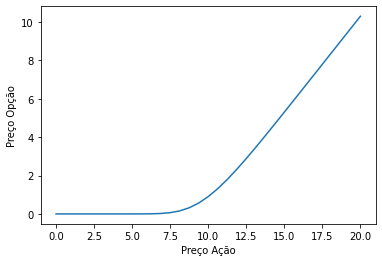

In [1451]:
fig = plt.figure()

plt.xlabel('Preço Ação')
plt.ylabel('Preço Opção')

plt.plot(z.rangeP(), g[-1])
plt.show()
fig.savefig("perfil")

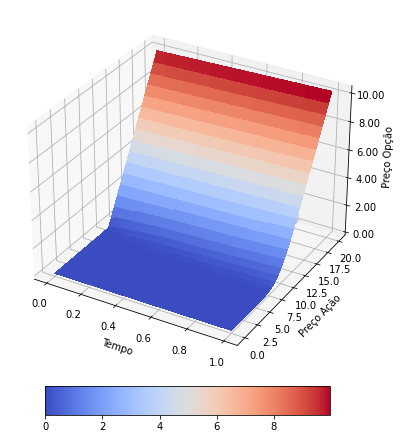

In [1464]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6), constrained_layout=True)

Y = z.rangeP()
X = z.rangeT()
X, Y = np.meshgrid(X, Y)
Z = z.callPrice()


surf = ax.plot_surface(X, Y, Z.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.xlabel('Tempo')
plt.ylabel('Preço Ação')
ax.set_zlabel('Preço Opção')
# Customize the z axis.
#ax.set_zlim(0, max(Z))

# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10, location = 'bottom')
fig.savefig("superficie")
plt.show()
